-The main goal of this project is to test my knowledge by developing a machine learning model that can classify items by images into predefined categories using taught algorithms from class and their extensions. This project uses the RealWaste dataset, a collection of authentic, labeled images of waste items provided by the UCI Machine Learning Repository: “https://archive.ics.uci.edu/dataset/908/realwaste.” The model is designed to help in the field of waste management, where accurate sorting can increase the efficiency of recycling and disposal processes, contributing to environmental sustainability.   
-The overall section structure of the project will be as following: 1. Data Preparation & Exploratory Analysis → 2. Training Preparation → 3. Model Building → 4. Model Training → 5. Evaluation.  
-In the end after Conclusion & reference , There is a robustness testing section, where you can upload your own waste image and test the classifier's accuracy.


In [5]:
#libararies:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pathlib
import cv2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter

\newpage
## 1. Data Preparation & Exploratory Analysis
In section 1, we load the dataset and check its basic characteristics. to run the code from your machine, you will need to download dataset folder from website: https://archive.ics.uci.edu/dataset/908/realwaste, and update the path of "DATA_DIR" with local folder.

In [8]:
DATA_DIR = "/Users/tomz/Desktop/datasci 3ml3/final project code/realwaste-main/RealWaste"
# Sets a uniform size for all images fed into your model, set batch size, seed for reproducibility and lets TensorFlow handle the data loading.
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE
#Converts DATA_DIR string into a Path object.
data_dir = pathlib.Path(DATA_DIR)
#image_paths[i] is the filesystem path to the i-th image; labels[i] is the integer class label for that same image.
class_names = sorted([p.name for p in data_dir.iterdir() if p.is_dir()])
image_paths, labels = [], []
for idx, cls in enumerate(class_names):
    for img_path in (data_dir/cls).glob('*'):
        image_paths.append(str(img_path))
        labels.append(idx)
num_classes = len(class_names)
print("Number of classes:", num_classes)
print("Classes:", class_names)

# Count how many times each label index appears
label_counts = Counter(labels)
# Print out counts per class
for idx, cls in enumerate(class_names):
    print(f"{cls}: {label_counts[idx]} images")

Number of classes: 9
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Cardboard: 461 images
Food Organics: 411 images
Glass: 420 images
Metal: 790 images
Miscellaneous Trash: 495 images
Paper: 500 images
Plastic: 921 images
Textile Trash: 318 images
Vegetation: 436 images


We can observe that the images' distribution between categories is imbalanced. For example, Plastic is the largest class with 921 images, while Textile Trash is the smallest with only 318 images. This feature can bias our model toward the majority classes and hurt performance on the rarer categories, and will be considered in following sections. 

## 2. Training Preparation  
Now apply data preparation before model's building and training. We will use TensorFlow and Keras libraries to build the model. The data pipeline will include the following steps: data split, preprocessing, pipelines, data augmentation.

In [ ]:
# split:
paths_trainval, paths_test, labels_trainval, labels_test = train_test_split(
    image_paths, labels,
    test_size=0.1,
    stratify=labels,
    random_state=SEED
)
val_fraction = 0.2 / 0.9  # 20% of total within trainval
paths_train, paths_val, labels_train, labels_val = train_test_split(
    paths_trainval, labels_trainval,
    test_size=val_fraction,
    stratify=labels_trainval,
    random_state=SEED
)
# Data Loading & Preprocessing Function
# A: Define a loader + resizer
def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use decode_jpeg instead of decode_image
    image = tf.image.resize(image, IMG_SIZE)
    return image, label
# B: Create tf.data datasets
train_ds = tf.data.Dataset.from_tensor_slices((paths_train, labels_train))
val_ds   = tf.data.Dataset.from_tensor_slices((paths_val,   labels_val))
test_ds  = tf.data.Dataset.from_tensor_slices((paths_test,  labels_test))
# C: Map, shuffle, batch, cache, prefetch: 
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1000, seed=SEED).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
val_ds   = val_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
test_ds  = test_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
#  DATA AUGMENTATION 
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

\newpage

## 3. Model Building
In this section, we set up our image classifier using transfer learning. We load MobileNetV2 pretrained on ImageNet, freeze its layers, and add a small custom head (global pooling, dropout, a dense layer, and softmax) to learn from our waste images. Then to balance our uneven classes, we calculate class weights and pass them into training. Finally, we add callbacks to stop if validation loss doesn’t improve, and ReduceLROnPlateau to lower the learning rate when needed.



In [ ]:
# BUILD MODEL (Transfer Learning): pretraine CNN, drop original classification, 
# initialize with learned filters for feneral visual features.
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
# input layer that's same as resized images (should be (256×256×3)), 
# data_augmentation: applies random flips/rotations/zooms on the fly, preprocess_input: scales pixels the way MobileNetV2 expects, Call into base_model with training=False to ensure layers like BatchNorm stay in inference mode.
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
# add GlobalAveragePooling2D,Dropout layers, Dense(128, relu),Dense(num_classes, softmax):
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)
# Tracking accuracy on train/val helps you monitor learning.
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

/var/folders/k5/dclrkvks01773htgfg01dq_w0000gn/T/ipykernel_51812/3174144552.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

- from above summary, get that The model augments and preprocesses 256×256 images, then uses a frozen MobileNetV2 to extract features, followed by pooling, dropout, and dense layers to classify images into nine waste categories while preventing overfitting.

In [ ]:
# COMPUTE CLASS WEIGHTS 
all_labels = labels_train
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)
# CALLBACKS 
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)
]

Class weights: {0: np.float64(1.1437908496732025), 1: np.float64(1.282793209876543), 2: np.float64(1.2566137566137565), 3: np.float64(0.6680731364275668), 4: np.float64(1.0677585099550417), 5: np.float64(1.0555555555555556), 6: np.float64(0.5736714975845411), 7: np.float64(1.6641641641641642), 8: np.float64(1.2112932604735884)}


## 4. Model Training
Runs for up to 15 epochs, applying class weights to handle category imbalance, and using callbacks for early stopping if needed:

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)

In [ ]:
model.save("realwaste_classifier.keras")

## 5. Evaluation
demonstrates model's performance by summaries and visualizations.

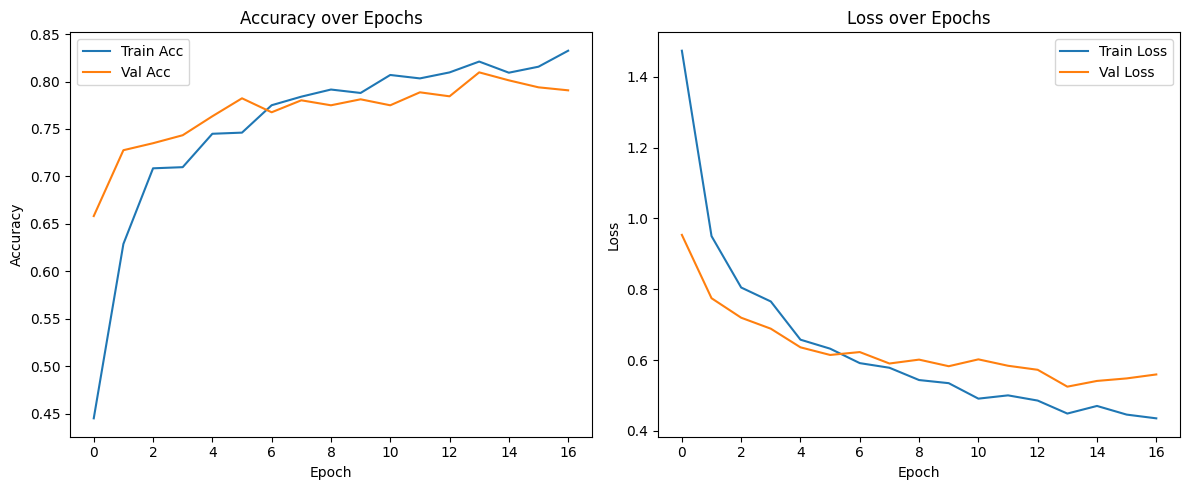

In [ ]:
# Plot performance
plt.figure(figsize=(12, 5))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}   Test Accuracy: {test_acc:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 366ms/step - accuracy: 0.8320 - loss: 0.4924
Test Loss: 0.4600   Test Accuracy: 0.8424


2025-05-14 11:13:23.211876: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.76      0.85      0.80        46
      Food Organics       0.95      0.98      0.96        41
              Glass       0.74      0.81      0.77        42
              Metal       0.92      0.77      0.84        79
Miscellaneous Trash       0.74      0.74      0.74        50
              Paper       0.83      0.90      0.87        50
            Plastic       0.85      0.78      0.81        92
      Textile Trash       0.83      0.94      0.88        32
         Vegetation       0.93      0.98      0.96        44

           accuracy                           0.84       476
          macro avg       0.84      0.86      0.85       476
       weighted avg       0.85      0.84      0.84       476



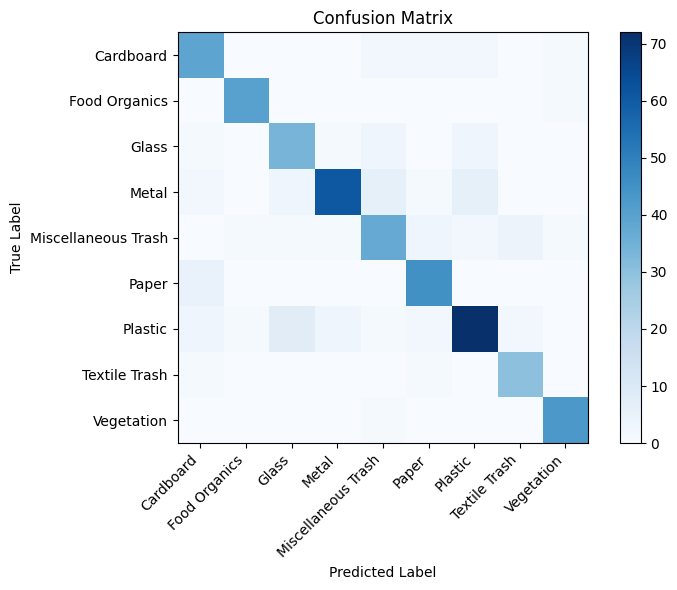

In [ ]:
# Detailed metrics, learned this method from youtuber Nochnack, N. 
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45, ha='right')
plt.yticks(ticks, class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

evaluation summary:

- The accuracy, loss over epochs plots shows no big overfitting and solid learning performance, with validation accuracy stablizes above 75% and validation loss below 0.8.
- The model is evaluated on a test set to measure its generalization performance. Test accuracy of 84% and a test loss of 0.46 shows solid performance in classifying real-world waste items.
- Classification report shows that the model performs well overall, with especially high accuracy on Vegetation and Food Organics. However, it struggles more with classes like Glass and Miscellaneous Trash, where predictions are more often confused with other categories.
- The confusion matrix shows darkest colors for metal and plastic however, but i think it implies the model saw more examples of those classes in the test set and got many of them right. Their diagonal cells are large due to higher support, not necessarily better performance.



### prediction visualization

plot first 9 test images, color correct predictions in blue and incorrect predictions in red.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


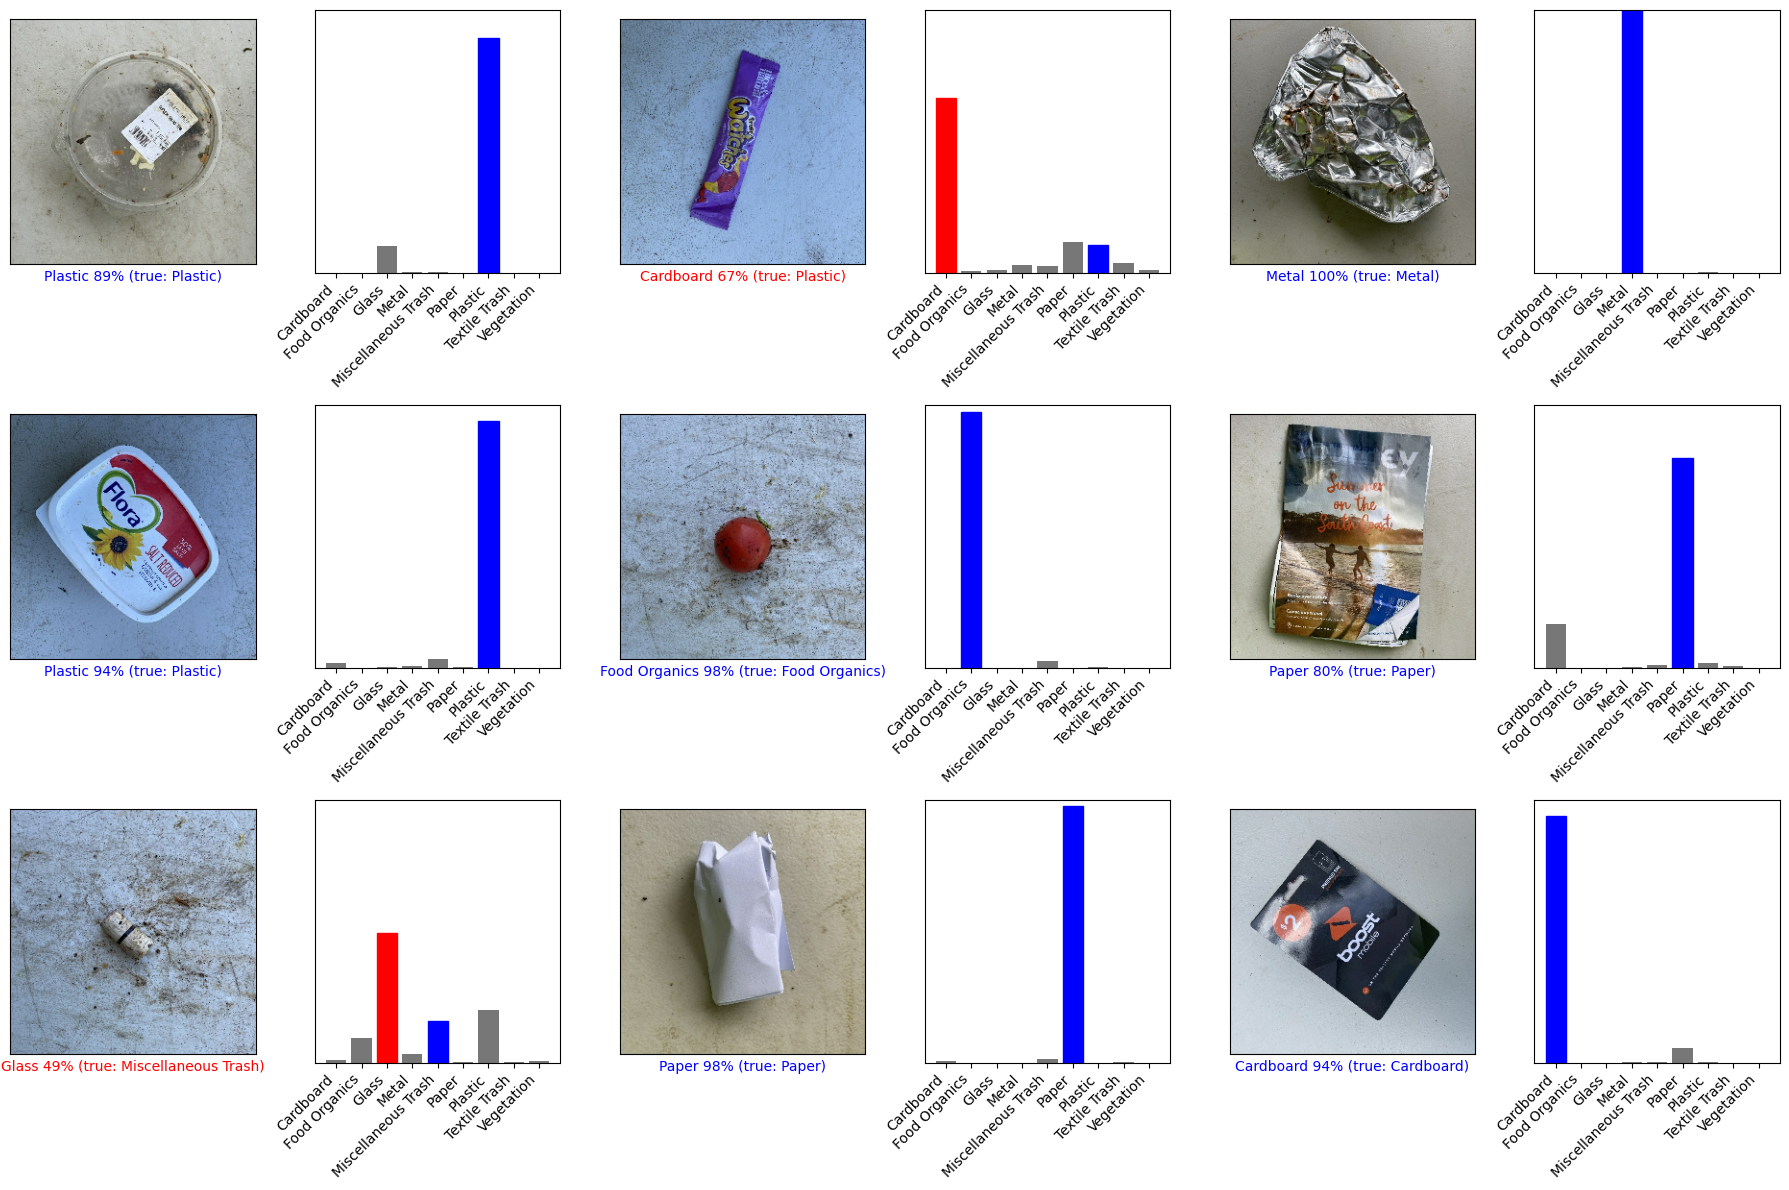

In [ ]:
# prediction visualization
def plot_waste_image(i, predictions_array, true_label, img):
    """
    Plots the image with a colored label: blue if correct, red if incorrect.
    """
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.numpy().astype('uint8'))
    predicted = np.argmax(predictions_array)
    color = 'blue' if predicted == true_label else 'red'
    plt.xlabel(f"{class_names[predicted]} {100*np.max(predictions_array):2.0f}% (true: {class_names[true_label]})", color=color)


def plot_waste_value_array(i, predictions_array, true_label):
    """
    Plots a bar chart of the prediction probabilities for each class,
    coloring the predicted class red and the true class blue.
    """
    plt.grid(False)
    plt.xticks(range(num_classes), class_names, rotation=45, ha='right')
    plt.yticks([])
    bars = plt.bar(range(num_classes), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted = np.argmax(predictions_array)
    bars[predicted].set_color('red')
    bars[true_label].set_color('blue')

# Grab a batch from the test dataset
# Here we visualize the first 9 images from test_ds
for test_images, test_labels in test_ds.take(1):
    break
predictions = model.predict(test_images)

plt.figure(figsize=(18, 12))
rows = 3
cols = 3
for i in range(rows*cols):
    # Image subplot
    plt.subplot(rows, cols*2, 2*i+1)
    plot_waste_image(i, predictions[i], test_labels[i].numpy(), test_images[i])
    # Probability bar subplot
    plt.subplot(rows, cols*2, 2*i+2)
    plot_waste_value_array(i, predictions[i], test_labels[i].numpy())

plt.tight_layout()
plt.show()


# Conclusion: 

### The project successfully applied transfer learning using MobileNetV2 for waste classification into 9 categories, achieving a test accuracy of 84%. By leveraging pre-trained CNN features and data augmentation, the model generalized well across most categories. However, class-specific precision metrics revealed that underrepresented classes could benefit from additional training data.
### In prediction evaluaiton, we observe some misclassifications(for example confusing paper and cardboard) may have small real-world impact since these materials are often processed together in recycling. This suggests the model may be penalized for acceptable mistakes, and its performance could improve by further adjustement like combine label categories, and better reflect actual waste management practices.

references: 

- Single, S., Iranmanesh, S., & Raad, R. (2023). RealWaste [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5SS4G.
- imageClassification GitHub Repository
Nochnack, N. (n.d.). ImageClassification [GitHub repository]. GitHub. Retrieved April 23, 2025, from https://github.com/nicknochnack/ImageClassification 
- MobileNetV2 API Documentation
TensorFlow Developers. (2024, June 7). tf.keras.applications.MobileNetV2 (TensorFlow v2.16.1) [API documentation]. TensorFlow. Retrieved April 23, 2025, from https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2 

\newpage
### classifier result demenstration: replace 'metalbottel.jpg' using your own image to try!

In [ ]:
from keras.models import load_model
model = load_model("realwaste_classifier.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


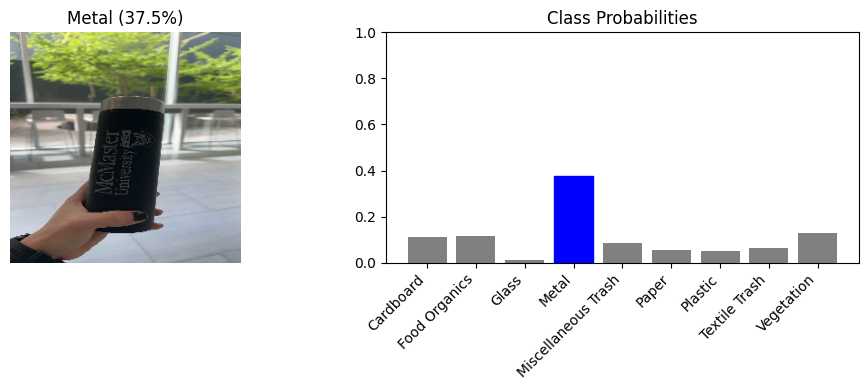

In [ ]:
# Ensure these match your training setup
IMG_SIZE    = (256, 256)
class_names = [
    'Cardboard', 'Food Organics', 'Glass', 'Metal',
    'Miscellaneous Trash', 'Paper', 'Plastic',
    'Textile Trash', 'Vegetation'
]
model       = model  # replace with your model variable
# 1) Load image, convert BGR→RGB, and resize
img_bgr      = cv2.imread('metalbottel.jpg')  # replace with your image path
if img_bgr is None:
    raise FileNotFoundError("Couldn't find image")
img_rgb      = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_resized  = cv2.resize(img_rgb, IMG_SIZE)
# 2) Predict (model’s built-in preprocessing layers will run automatically)
input_batch = np.expand_dims(img_resized, 0)       # shape (1,256,256,3)
preds        = model.predict(input_batch)[0]      # shape (9,)
# 3) Extract top prediction
pred_idx     = int(np.argmax(preds))
pred_label   = class_names[pred_idx]
pred_conf    = preds[pred_idx] * 100
# 4) Display image + label
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_resized)
plt.axis('off')
plt.title(f"{pred_label} ({pred_conf:.1f}%)")
# 5) Display probability distribution
plt.subplot(1, 2, 2)
bars = plt.bar(range(len(class_names)), preds, color='gray')
bars[pred_idx].set_color('blue')
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.ylim(0, 1)
plt.title("Class Probabilities")
plt.tight_layout()
plt.show()


In [ ]:
for name, prob in zip(class_names, preds):  
    print(f"{name:20s} → {prob:.3f}")

Cardboard            → 0.112
Food Organics        → 0.118
Glass                → 0.012
Metal                → 0.375
Miscellaneous Trash  → 0.085
Paper                → 0.056
Plastic              → 0.052
Textile Trash        → 0.062
Vegetation           → 0.128
